In [1]:
# Feature Extraction (Özellik Çıkarımı) : Ham veriden değişken, özellik üretmek.
# Yapısal ve yapısal olmayan verilerden değişken üretmek üzere ikiye ayrılır.
# Neden feature extraction ? Elimizde bir yazı, resim, ses olduğunda (yapısal olmayan) bunları matematiksel şeylere yani nümerik temsillere dönüştürmeliyiz.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [17]:
#Binary Features : Flag, bool, True-False
def load():
  data = pd.read_csv("titanic.csv")
  return data

df = load()
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype("int") #Kabin numarası olanlar ve olmayanlar olarak bool değişken dönüşümü yaptık.

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_CABIN_BOOL
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [20]:
df.groupby("NEW_CABIN_BOOL").agg({"Survived":"mean"})
#Gözlemlemiş olduğumuz gibi kabin numarası olanların hayatta kalma oranı kabin bumarası olmayanlara kıyasla daha yüksek.
#Normalde kabin numarası değişkeninin boş olması bizi çok alakadar etmiyor gibi görünebilir ancak bir önem arz ettiğini bu çıkarımlarımızda görmüş olduk.

,Survived
NEW_CABIN_BOOL,
0,0.299854
1,0.666667


In [21]:
#İki grubun oranını hesaplayalım. Görelim; bu işlem önemli miydi ?
from statsmodels.stats.proportion import proportions_ztest
test_stat, pvalue = proportions_ztest(count = [df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].sum(),#kabin numarası olup hayatta kalanlar
                                             df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].sum()],#kabin numarası olmayıp hayatta kalanlar
                                      nobs = [df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].shape[0],#kabin numarası olanlar kaç kişi
                                             df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].shape[0]])#kabin numarası olmayanlar kaç kişi
#count->başarı sayısı, nobs-> gözlem sayısı.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
#p1 ve p2 oranları arasında fark yok. Yani iki grubun kabin numarası olan ve olmayanların hayatta kalıp kalmadığını ifade ediyor.
#İki arasında oran yoktur diyen h0 hipotezi, p-value değeri 0.05den küçük olduğundan dolayı reddedilir. Aralarında anlamlı bir fark var gibi.
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 9.4597, p-value = 0.0000


In [23]:
#Bu değişkenler gemideki kişilerin akrabalıklarını belirtiyor. Eğer bunların toplamı 0 sa bu kişi yalnız olacağından new_is_alone değişkeni yes olacak.
df.loc[((df["SibSp"] + df["Parch"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SibSp"] + df["Parch"]) == 0), "NEW_IS_ALONE"] = "YES"
df.groupby("NEW_IS_ALONE").agg({"Survived":"mean"})

,Survived
NEW_IS_ALONE,
NO,0.505650
YES,0.303538


In [24]:
#Yukarıda görüldüğü gibi yalnız olanların hayatta kalma oranı daha düşük.
#Oran testini bir de bu değişken için yapalım.
test_stat, pvalue = proportions_ztest(count = [df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].sum(),
                                             df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].sum()],
                                      nobs = [df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].shape[0],
                                             df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].shape[0]])

print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))
#Görüldüğü üzere p-value değerimiz 0.05den küçük. Bu mutlak olarak hayatta kalma durumunu etkilediiğini göstermez ama bu değişkenin göz ardı edilemeyeceğini gösterir.
#Daha net bir şekilde bu etki modellemede görülür.

Test Stat = -6.0704, p-value = 0.0000


**TEXT FEATURES**

In [25]:
#Textler üzerinden özellik üretmek.Name üzerindeki değişkenlerden veriler elde etmek isteyelim.
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_CABIN_BOOL,NEW_IS_ALONE
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,NO
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,NO
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,YES
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,NO
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,YES


In [26]:
#Letter Count -> Harf saydırma. Mesela bir isimde kaç harf olduğunu çıkarabiliriz.
df["NEW_NAME_COUNT"] =df["Name"].str.len()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_CABIN_BOOL,NEW_IS_ALONE,NEW_NAME_COUNT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,NO,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,NO,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,YES,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,NO,44
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,YES,24


In [27]:
#Word Count -> Kelime sayma
df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_CABIN_BOOL,NEW_IS_ALONE,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,NO,23,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,NO,51,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,YES,22,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,NO,44,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,YES,24,4


In [28]:
#Özel Yapıları Yakalamak (DR, MR, MISS)
df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
df.groupby("NEW_NAME_DR").agg({"Survived" : ["mean","count"]})
#Görüldüğü gibi doktor olanların hayatta kalma oranı daha yüksek.
#Doktor sayısı az olmasına rağmen. Kayda değer bir bilgidir.

Survived      
                mean count
NEW_NAME_DR               
0            0.38252   881
1            0.50000    10

**Regex ile değişken üretmek**

In [29]:
df["NEW_TITLE"] =df.Name.str.extract(" ([A-Za-z]+)\.", expand =False) #" ([A-Za-z]+)\." -> Önünde boşluk sonunda nokta olacak, büyük ya da küçük harflerden oluşacak şekildeki ifadeler. Dr, Miss, Mrs gibi ünvan belirten ifadeler.
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_CABIN_BOOL,NEW_IS_ALONE,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,NO,23,4,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,NO,51,7,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,YES,22,3,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,NO,44,7,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,YES,24,4,0,Mr


In [30]:
#Bu ifadelerin hayatta kalma ve yaşlarının ortalamasını ve sayılarını aldık. Bu şekilde ürettiğimiz değişken üzerinden daha okunabilir ve çıkarım yapılabilir bilgiler elde ettik.
df[["NEW_TITLE","Survived","Age"]].groupby(["NEW_TITLE"]).agg({"Survived":"mean",
                                                               "Age" : ["count", "mean"]})


Survived   Age           
               mean count       mean
NEW_TITLE                           
Capt       0.000000     1  70.000000
Col        0.500000     2  58.000000
Countess   1.000000     1  33.000000
Don        0.000000     1  40.000000
Dr         0.428571     6  42.000000
Jonkheer   0.000000     1  38.000000
Lady       1.000000     1  48.000000
Major      0.500000     2  48.500000
Master     0.575000    36   4.574167
Miss       0.697802   146  21.773973
Mlle       1.000000     2  24.000000
Mme        1.000000     1  24.000000
Mr         0.156673   398  32.368090
Mrs        0.792000   108  35.898148
Ms         1.000000     1  28.000000
Rev        0.000000     6  43.166667
Sir        1.000000     1  49.000000

**Date değişkenleri üretmek**

In [124]:
data = pd.read_csv("course_reviews.csv")
data.head()

,Rating,Timestamp,Enrolled,Progress,Questions Asked,Questions Answered
0,5.0,2021-02-05 07:45:55,2021-01-25 15:12:08,5.0,0.0,0.0
1,5.0,2021-02-04 21:05:32,2021-02-04 20:43:40,1.0,0.0,0.0
2,4.5,2021-02-04 20:34:03,2019-07-04 23:23:27,1.0,0.0,0.0
3,5.0,2021-02-04 16:56:28,2021-02-04 14:41:29,10.0,0.0,0.0
4,4.0,2021-02-04 15:00:24,2020-10-13 03:10:07,10.0,0.0,0.0


In [125]:
data.info() #Time değişkenlerinin object türünde olduğundan çevirme işlemi yapmalıyız.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rating              4323 non-null   float64
 1   Timestamp           4323 non-null   object 
 2   Enrolled            4323 non-null   object 
 3   Progress            4323 non-null   float64
 4   Questions Asked     4323 non-null   float64
 5   Questions Answered  4323 non-null   float64
dtypes: float64(4), object(2)
memory usage: 202.8+ KB


In [126]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"], format="%Y-%m-%d")

In [127]:
data.info() #artık değişkenimiz datetime formatına dönüşmüş oldu.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Rating              4323 non-null   float64       
 1   Timestamp           4323 non-null   datetime64[ns]
 2   Enrolled            4323 non-null   object        
 3   Progress            4323 non-null   float64       
 4   Questions Asked     4323 non-null   float64       
 5   Questions Answered  4323 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 202.8+ KB


In [128]:
#Year
data["Year"] = data["Timestamp"].dt.year
#Month
data["Month"] = data["Timestamp"].dt.month
#Year different
data["Year_diff"] = date.today().year - data["Timestamp"].dt.year
#Month diff (İki tarih arasındaki ay farkı): yıl farkı + ay farkı
data["Month_diff"] = (date.today().year - data["Timestamp"].dt.year) * 12 + date.today().month - data["Timestamp"].dt.month
#Day name
data["Day_name"] = data["Timestamp"].dt.day_name()

data.head()

,Rating,Timestamp,Enrolled,Progress,Questions Asked,Questions Answered,Year,Month,Year_diff,Month_diff,Day_name
0,5.0,2021-02-05 07:45:55,2021-01-25 15:12:08,5.0,0.0,0.0,2021,2,1,17,Friday
1,5.0,2021-02-04 21:05:32,2021-02-04 20:43:40,1.0,0.0,0.0,2021,2,1,17,Thursday
2,4.5,2021-02-04 20:34:03,2019-07-04 23:23:27,1.0,0.0,0.0,2021,2,1,17,Thursday
3,5.0,2021-02-04 16:56:28,2021-02-04 14:41:29,10.0,0.0,0.0,2021,2,1,17,Thursday
4,4.0,2021-02-04 15:00:24,2020-10-13 03:10:07,10.0,0.0,0.0,2021,2,1,17,Thursday


In [129]:
#Feature Interactions (Özellik Etkileşimleri)
df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [130]:
#Yaş ve sınıf değişkenlerinin çarpımının büyük veya küçük olması teorik olarak bir şeyi ifade edecektir. (pclass 1-3 aralığında değerler alıyor.)
# Yaşı büyük veya küçük olanların yolculuk sınıflarına göre refah durumlarıyla ilgili bir sonuç ortaya çıkarmak 
df["NEW_AGE_PCLASS"] = df["Age"] * df["Pclass"]
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_AGE_PCLASS
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,66.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,78.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,105.0


In [36]:
#Yaş aralıklarına göre isimlendirmeler yaptık.
df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1
df.loc[(df["Age"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["Age"] >= 18) & (df["Age"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 56), "NEW_AGE_CAT"] = "senior"

df.loc[(df["Sex"] == "male") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["Sex"] == "male") & (df["Age"] > 21) & (df["Age"] <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["Sex"] == "male") & (df["Age"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["Sex"] == "female") & (df["Age"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["Sex"] == "female") & (df["Age"] > 21) & (df["Age"] <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["Sex"] == "female") & (df["Age"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [37]:
#Bu şekilde yaş grubu ve cinsiyete göre hayatta kalma oranlarını gözlemleyebiliyoruz.
df.groupby("NEW_SEX_CAT")["Survived"].mean() 

NEW_SEX_CAT
maturefemale    0.775000
maturemale      0.199301
seniorfemale    0.941176
seniormale      0.127660
youngfemale     0.678571
youngmale       0.250000
Name: Survived, dtype: float64

#Titanic Uçtan Uca Feature Engineering & Data Preprocessing

In [87]:
df = load()
df.shape

(891, 12)

In [88]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [89]:
#Yolcuların hayatta kalıp kalamayacağını bu veri seti üzerinden değerlendireceğiz. 
#Hepsi büyük küçük harflerden oluştuğundan kolaylık olsun diye hepsini küçülttük.
df.columns = [col.lower() for col in df.columns]
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [90]:
#1.MADDE : Değişken mühendisliği (FEATURE ENGINEERING)
#Bazı değişkenler birbiriyle ilişkili, bazen yeni üretilen değişkenleri daha sonra ön işlemeden geçirilmesi gerekebilir bazen de önce ön işleme yapıp sonra yeni değişken üretmemiz gerekilebilir.
#cabin bool
df["NEW_CABIN_BOOL"] = df["cabin"].notnull().astype('int')
#name count
df["NEW_NAME_COUNT"] = df["name"].str.len()
#name word count
df["NEW_NAME_WORD_COUNT"] = df["name"].apply(lambda x: len(str(x).split(" ")))
#name dr
df["NEW_NAME_DR"] = df["name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))
#name title : miss, mrs, dr, cont...
df["NEW_TITLE"] = df.name.str.extract(' ([A-Za-z]+)\.', expand=False)
#age_pclass
df["NEW_AGE_PCLASS"] = df["age"] * df["pclass"]
#family size
df["NEW_FAMILY_SIZE"] = df["sibsp"] + df["parch"] + 1
#is alone
df.loc[((df["sibsp"] + df["parch"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["sibsp"] + df["parch"]) == 0), "NEW_IS_ALONE"] = "YES"
#age level
df.loc[(df["age"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["age"] >= 18) & (df["age"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["age"] >= 56), "NEW_AGE_CAT"] = "senior"
#sex x age
df.loc[(df["sex"] == "male") & (df["age"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["sex"] == "male") & (df["age"] > 21) & (df["age"] <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["sex"] == "male") & (df["age"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["sex"] == "female") & (df["age"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["sex"] == "female") & (df["age"] > 21) & (df["age"] <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["sex"] == "female") & (df["age"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [91]:
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,...,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_AGE_PCLASS,NEW_FAMILY_SIZE,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,23,4,0,Mr,66.0,2,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,51,7,0,Mrs,38.0,2,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,22,3,0,Miss,78.0,1,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,44,7,0,Mrs,35.0,2,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,24,4,0,Mr,105.0,1,YES,mature,maturemale


In [92]:
#Hangi değişkenlerin kategorik hangilerinin numerik vs olduğunu bilmediğimizden bu fonksiyonla buluyoruz.
def grab_col_names(dataframe, cat_th=10, car_th=20): 
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]

  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int","float"]]
  
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]

  cat_cols = num_but_cat + cat_cols
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int","float"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f"Categorical Columns: {len(cat_cols)}")
  print(f"Numerical Columns: {len(num_cols)}")
  print(f"Categoric but Cardinal: {len(cat_but_car)}")
  print(f"Numeric but Categoric: {len(num_but_cat)}")

  return cat_cols, num_cols, cat_but_car

In [93]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 22
Categorical Columns: 14
Numerical Columns: 5
Categoric but Cardinal: 3
Numeric but Categoric: 8


In [94]:
cat_cols

['survived',
 'pclass',
 'sibsp',
 'parch',
 'NEW_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE',
 'sex',
 'embarked',
 'NEW_TITLE',
 'NEW_IS_ALONE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT']

In [95]:
#Passenger_id numerik bir değişken değil bunu buradan çıkarıyoruz.
num_cols

['passengerid', 'age', 'fare', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [96]:
num_cols = [col for col in num_cols if "passengerid" not in col]

In [97]:
num_cols

['age', 'fare', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [98]:
cat_but_car

['name', 'ticket', 'cabin']

In [99]:
#Outlier değişkenleri kontrol etmek için :
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
  quantile1 = dataframe[col_name].quantile(q1)
  quantile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quantile3 - quantile1
  up_limit = quantile3 + 1.5 * interquantile_range
  low_limit = quantile1 - 1.5 * interquantile_range
  return low_limit, up_limit
  
def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [ ]:
for col in num_cols:
  print(col, check_outlier(df,col))

In [101]:
#Eşik değerlerle bu aykırı değerleri değiştirmek için :
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [103]:
for col in num_cols:
  replace_with_thresholds(df,col)

In [104]:
#tekrardan aykırı değer kontolü sağlayalım.
for col in num_cols:
  print(col, check_outlier(df,col))

age False
fare False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [105]:
#eksik değerlerin kontrolünü sağlayalım
def missing_values_table(dataframe, na_name=False): #na_name eksik değerlerin bullunduğu değişkenlerin ismi
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum()/dataframe.shape[0] *100).sort_values(ascending=False)
  missing_df=pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=['n_miss','ratio']) #concat ile birleştiriyoruz.
  print(missing_df, end="\n")
  if na_name:
    return na_columns

In [106]:
#yeni oluşturduğumuz değerler age e bağlı olduğundan ve age de kayıp değerler olduğundan yeni ürettiklerimizde de bunları gözlemleriz.
missing_values_table(df)

                n_miss  ratio
cabin              687  77.10
age                177  19.87
NEW_AGE_PCLASS     177  19.87
NEW_AGE_CAT        177  19.87
NEW_SEX_CAT        177  19.87
embarked             2   0.22


In [107]:
#Cabin yenine cabin bool adında değişkenimiz olduğundan cabin değerini df den çıkarabiliriz.
df.drop("cabin", inplace=True, axis=1)

In [108]:
#İstemediğimiz diğer değişkenlere de drop uygulayalım.
remove_cols=["ticket", "name"] #zaten bu değişkenler üzerinden yeni değişkenler üretmiştik.
df.drop(remove_cols, inplace=True,axis=1)

In [109]:
df["age"] = df["age"].fillna(df.groupby("NEW_TITLE")["age"].transform("median")) #oluşturmuş olduğumuz new title a göre groupbya alıp age değişkeninin eksik değerlerini medyan ile doldurduk.

In [110]:
#yaş değişkeninin boş kısımlarını medyan ile doldurduğumuzdan age üzerinden oluşturulan yeni değişkenleri tekrar oluşturmamız gerekiyor.

df["NEW_AGE_PCLASS"] = df["age"] * df["pclass"]
df.loc[(df["age"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["age"] >= 18) & (df["age"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["age"] >= 56), "NEW_AGE_CAT"] = "senior"
df.loc[(df["sex"] == "male") & (df["age"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["sex"] == "male") & (df["age"] > 21) & (df["age"] <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["sex"] == "male") & (df["age"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["sex"] == "female") & (df["age"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["sex"] == "female") & (df["age"] > 21) & (df["age"] <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["sex"] == "female") & (df["age"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [111]:
#sadece embarked kaldı.
missing_values_table(df)

          n_miss  ratio
embarked       2   0.22


In [112]:
# Bunu da mod ile dolduralım.
df =df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis = 0) 

In [113]:
#tekrardan boş değerleri kontrol edelim. hiç kalmış mı diye ?
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [114]:
#Eksik değerlerimizden kurtulduk. Ağaç yöntemini seçseydik kurtulmamayı seçebilirdik.
# MADDE 4: Label encoding
#İki sınıflı kategorik değişkenleri 0-1 olarak dönüştürmüştük. binary kolonları seçelim.
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
binary_cols

['sex', 'NEW_IS_ALONE']

In [115]:
#Bu iki değişkeni label encoding işlemine sokalım.
def label_encoder(dataframe, binary_col):
  labelencoder=LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

for col in binary_cols:
  df = label_encoder(df, col)

In [116]:
#Öncelikle rare encoding yapıyoruz ki olası indirgemeleri yaptıktan sonra one hot encoding uygulayabilelim.
#Rare encoding için önce rare analyser fonksiyonunu getiriyoruz.
def rare_analyser(dataframe, target, cat_cols):
  for col in cat_cols:
    print(col,":", len(dataframe[col].value_counts()))#ilgili kategorik değişkenin kaç sınıfı olduğu bilgisi.
    print(pd.DataFrame({"COUNT":dataframe[col].value_counts(),#sınıf frekansları
                        "RATIO":dataframe[col].value_counts()/len(dataframe),#sınıf oranları
                        "TARGET_MEAN":dataframe.groupby(col)[target].mean()}), end="\n\n\n") #target yani bağımlı değişkene göre groupby işlemi.

rare_analyser(df,"survived",cat_cols)


survived : 2
   COUNT     RATIO  TARGET_MEAN
0    549  0.616162          0.0
1    342  0.383838          1.0


pclass : 3
   COUNT     RATIO  TARGET_MEAN
1    216  0.242424     0.629630
2    184  0.206510     0.472826
3    491  0.551066     0.242363


sibsp : 7
   COUNT     RATIO  TARGET_MEAN
0    608  0.682379     0.345395
1    209  0.234568     0.535885
2     28  0.031425     0.464286
3     16  0.017957     0.250000
4     18  0.020202     0.166667
5      5  0.005612     0.000000
8      7  0.007856     0.000000


parch : 7
   COUNT     RATIO  TARGET_MEAN
0    678  0.760943     0.343658
1    118  0.132435     0.550847
2     80  0.089787     0.500000
3      5  0.005612     0.600000
4      4  0.004489     0.000000
5      5  0.005612     0.200000
6      1  0.001122     0.000000


NEW_CABIN_BOOL : 2
   COUNT     RATIO  TARGET_MEAN
0    687  0.771044     0.299854
1    204  0.228956     0.666667


NEW_NAME_WORD_COUNT : 8
    COUNT     RATIO  TARGET_MEAN
3     305  0.342312     0.291803
4    

In [117]:
#Rare encoder fonksiyonumuz:
def rare_encoder(dataframe, rare_perc):
  temp_df = dataframe.copy()
  rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O" and (temp_df[col].value_counts()/len(temp_df)<rare_perc).any(axis=None)]

  for var in rare_columns:
    tmp = temp_df[var].value_counts()/ len(temp_df) 
    rare_labels = tmp[tmp<rare_perc].index 
    temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var]) 
  return temp_df

In [118]:
#hepsini rare encoder yapmak çok mantıklı olmayabilir ancak genel bir çözüm ele aldığımızdan göz ardı edebiliriz.
df = rare_encoder(df, 0.01)

In [119]:
#ONE HOT ENCODING
#2 FAZLA VE 10DAN AZ EŞSİZ DEĞERE SAHİP DEĞİŞKENLERİ DÖNÜŞTÜRECEĞİZ.
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['pclass',
 'sibsp',
 'parch',
 'embarked',
 'NEW_NAME_WORD_COUNT',
 'NEW_TITLE',
 'NEW_FAMILY_SIZE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT']

In [120]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
  dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
  return dataframe

df = one_hot_encoder(df, ohe_cols)

In [121]:
df.head()

,passengerid,survived,sex,age,fare,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,...,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.0,7.2500,0,23,0,66.0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,0,38.0,65.6344,1,45,0,38.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,26.0,7.9250,0,22,0,78.0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,35.0,53.1000,1,44,0,35.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,35.0,8.0500,0,24,0,105.0,1,...,0,0,0,0,0,1,0,0,0,0


#MODEL


In [122]:
y = df["survived"]
X = df.drop(["passengerid", "survived"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=17)

from sklearn.ensemble import RandomForestClassifier
#x_train bağımsız, y_train bağımlı (target) değişkenler.
rf_model = RandomForestClassifier(random_state = 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8097014925373134

Hiç bir işlem yapmadan elde edilecek skor:

In [76]:
dff=load()
dff.dropna(inplace=True)
dff = pd.get_dummies(dff,columns=["Sex","Embarked"],drop_first =True)
y = dff["Survived"]
X=dff.drop(["PassengerId","Survived","Name","Ticket","Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=17)
rf_model = RandomForestClassifier(random_state = 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.7090909090909091

In [77]:
dff=load()
#dff.dropna(inplace=True)
dff = pd.get_dummies(dff,columns=["Sex","Embarked"],drop_first =True)
y = dff["Survived"]
X=dff.drop(["PassengerId","Survived","Name","Ticket","Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=17)
rf_model = RandomForestClassifier(random_state = 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

ValueError: ignored

Değişken değerlerinde nan olduğundan random forest hata verdi. Normalde random forest uygulamalarının bir çoğu nan değerlerde sorun çıkarmaz. Ama demek ki bu kullandığımız yöntem çıkarıyor xd

In [78]:
#Get_dummies yöntemini uygulamasaydık:
dff=load()
dff.dropna(inplace=True)
#dff = pd.get_dummies(dff,columns=["Sex","Embarked"],drop_first =True)
y = dff["Survived"]
X=dff.drop(["PassengerId","Survived","Name","Ticket","Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=17)
rf_model = RandomForestClassifier(random_state = 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

ValueError: ignored

String ifadeyi floata çeviremediğinden hata verdi. Çünkü sayısal değerler harici işlem yapamaz.

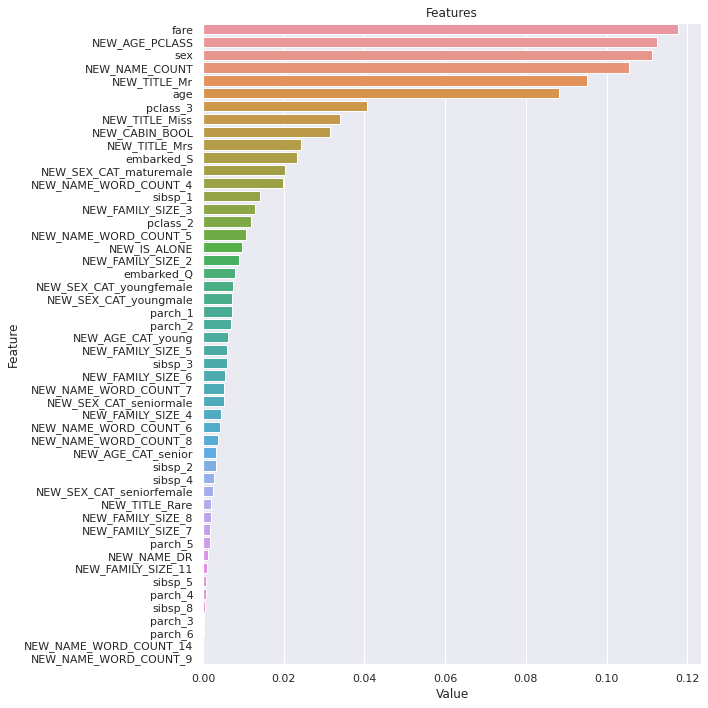

In [123]:
#Yeni türettiğimiz değişkenlere bakalım :
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
def plot_importance(model,features, num=len(X),save=False):
  feature_imp = pd.DataFrame({"Value" : model.feature_importances_, "Feature" : features.columns})
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1)
  sns.barplot(x="Value", y = "Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
  plt.title("Features")
  plt.tight_layout()
  plt.show()
  if save:
    plt.savefig("importances.png")

plot_importance(rf_model, X_train)
